In [1]:
import numpy as np
import os
from keras.layers import Conv3D, MaxPooling3D
from keras.layers import Dense, Dropout, Flatten
from keras.models import Sequential
from keras.layers import Activation, ZeroPadding3D, TimeDistributed, LSTM, GRU, Reshape
#from keras.utils import plot_model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import gc
from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.preprocessing import LabelEncoder
import sklearn
import seaborn as sns
import tensorflow as tf
from keras import regularizers
from tensorflow.keras.utils import to_categorical
from prettytable import PrettyTable
from matplotlib import pyplot as plt
import cv2
import time

# Noise Reduction 

In [5]:
import cv2
import os

def reduce_noise(input_folder, output_folder):
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Loop through each file in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith(".mp4"):  # Assuming all files are videos
            video_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename)

            # Open the video file
            cap = cv2.VideoCapture(video_path)
            frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            fps = int(cap.get(cv2.CAP_PROP_FPS))

            # Create VideoWriter object
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

            # Process each frame
            for _ in range(frame_count):
                ret, frame = cap.read()
                if ret:
                    # Apply Gaussian blur for noise reduction
                    blurred_frame = cv2.GaussianBlur(frame, (5, 5), 0)
                    out.write(blurred_frame)

            # Release resources
            cap.release()
            out.release()

            print(f"Noise reduction completed for {filename}")

# Example usage:
input_folder = "D:\\FINAL MAJOR20-2\\Dataset1.0"
output_folder = "D:\\FINAL MAJOR20-2\\Noise reduction\\output"
reduce_noise(input_folder, output_folder)


Noise reduction completed for a.mp4
Noise reduction completed for bye.mp4
Noise reduction completed for can.mp4
Noise reduction completed for cat.mp4
Noise reduction completed for demo.mp4
Noise reduction completed for dog.mp4
Noise reduction completed for hello.mp4
Noise reduction completed for here.mp4
Noise reduction completed for is.mp4
Noise reduction completed for lips.mp4
Noise reduction completed for my.mp4
Noise reduction completed for read.mp4
Noise reduction completed for you.mp4


# Converting to Frames

In [6]:
import os
import cv2

def extract_frames(video_folder, output_folder, num_frames=8):
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Iterate through each video file in the folder
    for filename in os.listdir(video_folder):
        if filename.endswith(".mp4") or filename.endswith(".avi"):
            video_path = os.path.join(video_folder, filename)
            video_name = os.path.splitext(filename)[0]

            # Create a subfolder for each video
            video_output_folder = os.path.join(output_folder, video_name)
            if not os.path.exists(video_output_folder):
                os.makedirs(video_output_folder)

            # Open the video file
            cap = cv2.VideoCapture(video_path)

            # Get the total number of frames in the video
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

            # Calculate the frame interval to get exactly num_frames frames
            frame_interval = max(1, total_frames // num_frames)

            frame_count = 0

            # Read and process each frame
            while(cap.isOpened() and frame_count < num_frames):
                ret, frame = cap.read()
                if not ret:
                    break

                # Save the frame
                output_frame_path = os.path.join(video_output_folder, f"{video_name}_frame_{frame_count}.jpg")
                cv2.imwrite(output_frame_path, frame)

                frame_count += 1

                # Move to the next frame based on the calculated interval
                cap.set(cv2.CAP_PROP_POS_FRAMES, frame_count * frame_interval)

            cap.release()

# Example usage:
video_dataset_folder = "D:\\FINAL MAJOR20-2\\Noise reduction\\output"
output_frames_folder = "D:\\FINAL MAJOR20-2\\Frames"
extract_frames(video_dataset_folder, output_frames_folder, num_frames=8)


# Converting Normal Frames into GLCM

In [7]:
import os
import cv2
import numpy as np
from skimage.feature import graycomatrix, graycoprops

def glcm_noise_reduction(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Compute the GLCM of the grayscale image
    glcm = graycomatrix(gray, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4])

    # Compute the mean of the GLCM
    mean_glcm = np.mean(glcm)

    # Subtract the mean from the original image to reduce noise
    reduced_noise_image = gray - mean_glcm

    return reduced_noise_image

# Specify the directory containing the folders with frames
root_dir = "D:\\FINAL MAJOR20-2\\Frames"

# Create a new folder to save all the noise-reduced images
new_root_dir = "D:\\FINAL MAJOR20-2\\output_denoised_image_folder"

# Loop over each folder (video)
for folder in os.listdir(root_dir):
    folder_path = os.path.join(root_dir, folder)
    new_folder_path = os.path.join(new_root_dir, folder)
    os.makedirs(new_folder_path, exist_ok=True)

    # Loop over each image (frame) in the folder
    for frame in os.listdir(folder_path):
        frame_path = os.path.join(folder_path, frame)

        # Read the image
        image = cv2.imread(frame_path)

        # Apply GLCM noise reduction
        reduced_noise_image = glcm_noise_reduction(image)

        # Save the noise-reduced image in the new folder
        cv2.imwrite(os.path.join(new_folder_path, frame), reduced_noise_image)

print('Noise reduction completed.')


Noise reduction completed.


# GLCM_CNN


In [28]:
import os
import imageio
import numpy as np
from skimage.feature import graycomatrix, graycoprops
from skimage import io
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LSTM
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import train_test_split

# Constants
IMAGE_SIZE = (112, 80)
NUM_CLASSES = 13
PATCH_SIZE = 35

# Load dataset
dataset_dir = "D:/FINAL MAJOR20-2/GLCM-LSTM/kaggleDataset/output_denoised_image_folder"
class_folders = os.listdir(dataset_dir)
classes = {class_name: i for i, class_name in enumerate(class_folders)}
num_samples = sum(len(os.listdir(os.path.join(dataset_dir, class_name))) for class_name in class_folders)

# Initialize arrays to store features and labels
X = np.zeros((num_samples, 6))  # 6 GLCM properties per patch
y = np.zeros((num_samples, NUM_CLASSES))

# Extract GLCM features for each image frame
index = 0
for class_name in class_folders:
    class_dir = os.path.join(dataset_dir, class_name)
    for image_file in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_file)
        image = imageio.imread(image_path)
        # Resize image to required size
        image = cv2.resize(image, IMAGE_SIZE)
        # Compute GLCM
        GLCM = graycomatrix(image, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4])
        features = []
        for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']:
            features.append(graycoprops(GLCM, prop)[0, 0])
        X[index] = np.array(features)
        y[index, classes[class_name]] = 1
        index += 1

# Save GLCM features (optional)
np.save('GLCM_features.npy', X)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.reshape(-1, 1, 1, 6)  # Batch size, height (1), width (1), features (6)
X_val = X_val.reshape(-1, 1, 1, 6)

# Reshape input data for LSTM
X_train = np.expand_dims(X_train, axis=1)
X_val = np.expand_dims(X_val, axis=1)

model = Sequential([
    Conv2D(128, (3, 3), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 6)),  # Change input_shape to accept 6 channels
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Reshape((5, 384)),  # Remove this line
    LSTM(256),
    Dense(512, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax')
])


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


# Define callback to display training and validation accuracy
class AccuracyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}/{self.params['epochs']}, Accuracy: {logs['accuracy']}, Val Accuracy: {logs['val_accuracy']}")

model.summary()

C:\Users\sumit\AppData\Local\Temp\ipykernel_12432\1348051977.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_path)


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_63 (Conv2D)          (None, 110, 78, 128)      7040      
                                                                 
 max_pooling2d_64 (MaxPoolin  (None, 55, 39, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_64 (Conv2D)          (None, 53, 37, 256)       295168    
                                                                 
 max_pooling2d_65 (MaxPoolin  (None, 26, 18, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_65 (Conv2D)          (None, 24, 16, 256)       590080    
                                                                 
 max_pooling2d_66 (MaxPoolin  (None, 12, 8, 256)     

In [29]:
start_time = time.time()

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[AccuracyCallback()])

print(history.history)

# Stop the timer
end_time = time.time()

# Compute the computational time
comp_time = end_time - start_time

model.save('GLCM_CNN.h5')
print(f'Training time: {comp_time}')

Epoch 1/100


ValueError: in user code:

    File "c:\Users\sumit\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\sumit\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\sumit\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\sumit\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 808, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\sumit\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\sumit\anaconda3\envs\tf\lib\site-packages\keras\engine\input_spec.py", line 263, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_16" is incompatible with the layer: expected shape=(None, 112, 80, 6), found shape=(None, 1, 1, 1, 6)


In [41]:
# Evaluate the model on the training data
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

# Evaluate the model on the validation data
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")


Training Accuracy: 10.84%
Validation Accuracy: 4.76%


# Training accuracy

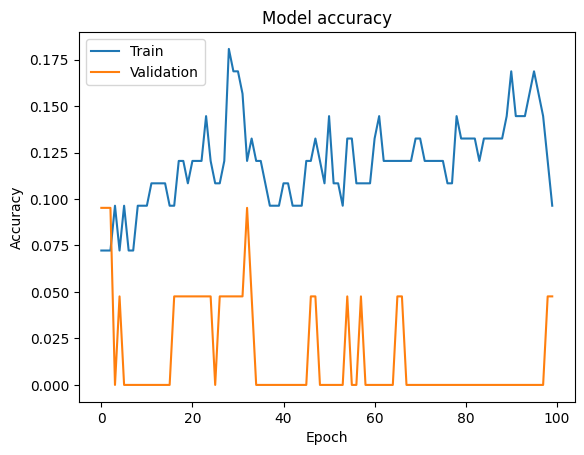

In [42]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# ROC CURVE

In [57]:
%pip install scipy==1.11.4

  You can safely remove it manually.
  You can safely remove it manually.



     ---------------------------------------- 0.0/60.4 kB ? eta -:--:--
     ------------------- ------------------ 30.7/60.4 kB 435.7 kB/s eta 0:00:01
     -------------------------------------- 60.4/60.4 kB 643.1 kB/s eta 0:00:00
   ---------------------------------------- 0.0/44.3 MB ? eta -:--:--
   ---------------------------------------- 0.5/44.3 MB 14.5 MB/s eta 0:00:04
    --------------------------------------- 0.7/44.3 MB 9.1 MB/s eta 0:00:05
    --------------------------------------- 0.9/44.3 MB 7.1 MB/s eta 0:00:07
    --------------------------------------- 1.0/44.3 MB 6.2 MB/s eta 0:00:08
    --------------------------------------- 1.0/44.3 MB 6.2 MB/s eta 0:00:08
    --------------------------------------- 1.0/44.3 MB 3.7 MB/s eta 0:00:12
   - -------------------------------------- 1.6/44.3 MB 5.0 MB/s eta 0:00:09
   - -------------------------------------- 1.7/44.3 MB 4.6 MB/s eta 0:00:10
   - -------------------------------------- 1.7/44.3 MB 4.6 MB/s eta 0:00:10
   

c:\Users\sumit\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


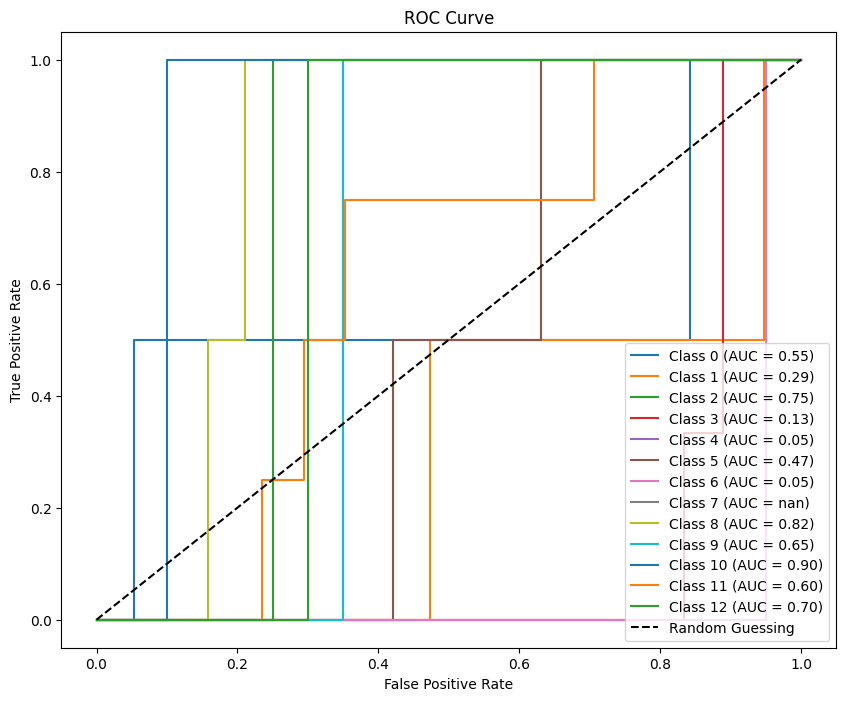

Training Loss: 2.473855495452881, Accuracy: 0.10843373835086823
Validation Loss: 2.7108070850372314, Accuracy: 0.0476190485060215


In [67]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have trained your model
# Get predictions on validation data
y_pred = model.predict(X_val)
y_true = y_val

# Convert y_true to single label format
y_true_single = np.argmax(y_true, axis=1)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve((y_true_single == i).astype(int), y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(NUM_CLASSES):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Display training and validation loss and accuracy
print(f"Training Loss: {train_loss}, Accuracy: {train_accuracy}")
print(f"Validation Loss: {val_loss}, Accuracy: {val_accuracy}")


# Confusion Matrix

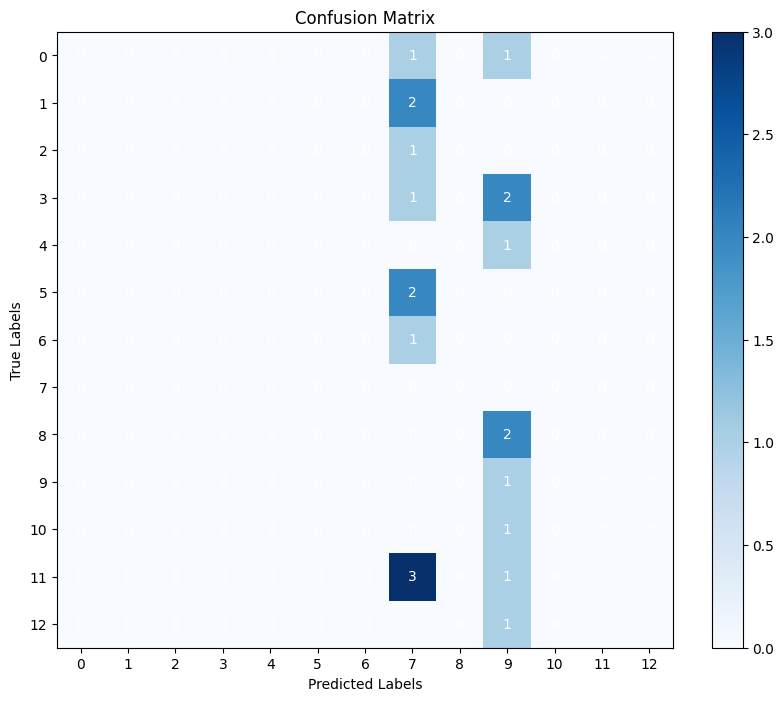

Training Loss: 2.473855495452881, Accuracy: 0.10843373835086823
Validation Loss: 2.7108070850372314, Accuracy: 0.0476190485060215


In [68]:
from sklearn.metrics import confusion_matrix

# Assuming you have trained your model
# Get predictions on validation data
y_pred = model.predict(X_val)
y_true = y_val

# Convert y_true to single label format
y_true_single = np.argmax(y_true, axis=1)

cm = confusion_matrix(y_true_single, np.argmax(y_pred, axis=1))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(np.arange(NUM_CLASSES))
plt.yticks(np.arange(NUM_CLASSES))
for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.show()

# Display training and validation loss and accuracy
print(f"Training Loss: {train_loss}, Accuracy: {train_accuracy}")
print(f"Validation Loss: {val_loss}, Accuracy: {val_accuracy}")


In [71]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from prettytable import PrettyTable
import pandas as pd

# Convert multilabel-indicator format to single label format
train_true_labels = np.argmax(y_train, axis=1)
validation_true_labels = np.argmax(y_val, axis=1)

# Assuming you already have the necessary variables defined in your code
train_predictions = model.predict(X_train)
validation_predictions = model.predict(X_val)

# Convert predictions to class labels
train_pred_labels = np.argmax(train_predictions, axis=1)
validation_pred_labels = np.argmax(validation_predictions, axis=1)

# Calculate metrics
train_report = classification_report(train_true_labels, train_pred_labels)
validation_report = classification_report(validation_true_labels, validation_pred_labels)

# Additional metrics using confusion matrix
train_conf_matrix = confusion_matrix(train_true_labels, train_pred_labels)
validation_conf_matrix = confusion_matrix(validation_true_labels, validation_pred_labels)

# Calculate precision, recall, F1 score, and support
train_precision, train_recall, train_f1_score, train_support = precision_recall_fscore_support(train_true_labels, train_pred_labels)
validation_precision, validation_recall, validation_f1_score, validation_support = precision_recall_fscore_support(validation_true_labels, validation_pred_labels)

# Create PrettyTable for training metrics
train_table = PrettyTable()
train_table.field_names = ["Class", "Precision", "Recall", "F1 Score", "Support"]

# Populate the table with training metrics
for class_name, precision, recall, f1_score, support in zip(
        range(NUM_CLASSES),
        train_precision,
        train_recall,
        train_f1_score,
        train_support
):
    train_table.add_row([class_name, precision, recall, f1_score, support])

# Create PrettyTable for validation metrics
validation_table = PrettyTable()
validation_table.field_names = ["Class", "Precision", "Recall", "F1 Score", "Support"]

# Populate the table with validation metrics
for class_name, precision, recall, f1_score, support in zip(
        range(NUM_CLASSES),
        validation_precision,
        validation_recall,
        validation_f1_score,
        validation_support
):
    validation_table.add_row([class_name, precision, recall, f1_score, support])

# Print tables
print("Training Metrics:")
print(train_table)

print("\nValidation Metrics:")
print(validation_table)

# Display training and validation loss and accuracy
print(f"Training Loss: {train_loss}, Accuracy: {train_accuracy}")
print(f"Validation Loss: {val_loss}, Accuracy: {val_accuracy}")

# Create DataFrames for training and validation metrics
train_df = pd.DataFrame({
    'Dataset': 'Training',
    'Class': range(NUM_CLASSES),
    'Precision': train_precision,
    'Recall': train_recall,
    'F1 Score': train_f1_score,
    'Support': train_support
})

validation_df = pd.DataFrame({
    'Dataset': 'Validation',
    'Class': range(NUM_CLASSES),
    'Precision': validation_precision,
    'Recall': validation_recall,
    'F1 Score': validation_f1_score,
    'Support': validation_support
})

# Concatenate DataFrames
combined_df = pd.concat([train_df, validation_df], ignore_index=True)

# Save combined DataFrame to an Excel sheet
combined_excel_path = 'combined_metricGLCM_LSTM-beforekfold.xlsx'
combined_df.to_excel(combined_excel_path, index=False)

print(f"Combined metrics saved to {combined_excel_path}")


c:\Users\sumit\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sumit\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sumit\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sumit\a

Training Metrics:
+-------+---------------------+---------------------+---------------------+---------+
| Class |      Precision      |        Recall       |       F1 Score      | Support |
+-------+---------------------+---------------------+---------------------+---------+
|   0   |         0.0         |         0.0         |         0.0         |    6    |
|   1   |         0.0         |         0.0         |         0.0         |    6    |
|   2   |         0.0         |         0.0         |         0.0         |    7    |
|   3   |         0.0         |         0.0         |         0.0         |    5    |
|   4   |        0.125        | 0.14285714285714285 | 0.13333333333333333 |    7    |
|   5   |         0.0         |         0.0         |         0.0         |    6    |
|   6   |         0.0         |         0.0         |         0.0         |    7    |
|   7   | 0.11904761904761904 |        0.625        |         0.2         |    8    |
|   8   |         0.0         |     

In [67]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Create an ImageDataGenerator object
# datagen = ImageDataGenerator(rescale=1./255)

# # Create a generator
# generator = datagen.flow_from_directory(
#     'D:\\New Dataset Lip Movement Projec\\FINAL YEAR PROJECT\\output_denoised_image_folder',
#     target_size=(150, 150),
#     batch_size=16,
#     class_mode='binary'
# )

# print(generator.batch_size)


Found 298 images belonging to 17 classes.
16
